# Lung Disease Classification menggunakan Video Vision Transformer
<br>Nama : Husni Na'fa Mubarok
<br>NIM : 121450078

## Import Package

In [1]:
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import keras
import librosa
import numpy as np
import os
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

## EDA and Data Cleaning

### Import Dataframe & Processing

In [2]:
train = pd.read_csv("/kaggle/input/airs-ai-in-respiratory-sounds/train.csv")
train = train[train['candidateID'] != '5ee582f2832c2']
print(train.info())
print(train.isnull().sum())
train

<class 'pandas.core.frame.DataFrame'>
Index: 545 entries, 0 to 545
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   candidateID          545 non-null    object 
 1   age                  545 non-null    int64  
 2   gender               545 non-null    int64  
 3   tbContactHistory     545 non-null    float64
 4   wheezingHistory      545 non-null    float64
 5   phlegmCough          545 non-null    float64
 6   familyAsthmaHistory  545 non-null    float64
 7   feverHistory         545 non-null    int64  
 8   coldPresent          397 non-null    float64
 9   packYears            545 non-null    int64  
 10  disease              545 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 51.1+ KB
None
candidateID              0
age                      0
gender                   0
tbContactHistory         0
wheezingHistory          0
phlegmCough              0
familyAsthmaHistory 

,candidateID,age,gender,tbContactHistory,wheezingHistory,phlegmCough,familyAsthmaHistory,feverHistory,coldPresent,packYears,disease
0,b87ea0dd760fa,43,1,0.0,1.0,0.0,0.0,0,NaN,0,1
1,b734834dec6d1,24,0,0.0,1.0,0.0,0.0,0,NaN,0,1
2,e000a41725f53,52,1,0.0,1.0,0.0,0.0,0,NaN,0,2
3,253ba780a0398,28,0,0.0,0.0,0.0,0.0,0,NaN,0,0
4,6663cd023ff3d,27,1,0.0,1.0,0.0,1.0,0,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...
541,3914c89d9086f,47,0,0.0,0.0,1.0,0.0,0,0.0,0,2
542,90ebadb136321,37,1,0.0,0.0,0.0,0.0,0,0.0,0,0
543,597cf5e1da982,42,0,0.0,0.0,1.0,0.0,0,1.0,0,2
544,1d21de658c4f2,79,0,0.0,0.0,1.0,0.0,0,0.0,280,2


### Drop Null Column

In [3]:
train = train.drop(columns=["coldPresent"])
train.isnull().sum()

candidateID            0
age                    0
gender                 0
tbContactHistory       0
wheezingHistory        0
phlegmCough            0
familyAsthmaHistory    0
feverHistory           0
packYears              0
disease                0
dtype: int64

### Sound Visualization & Processing

Waveform image saved to: /kaggle/working/waveform_images/waveforms.png


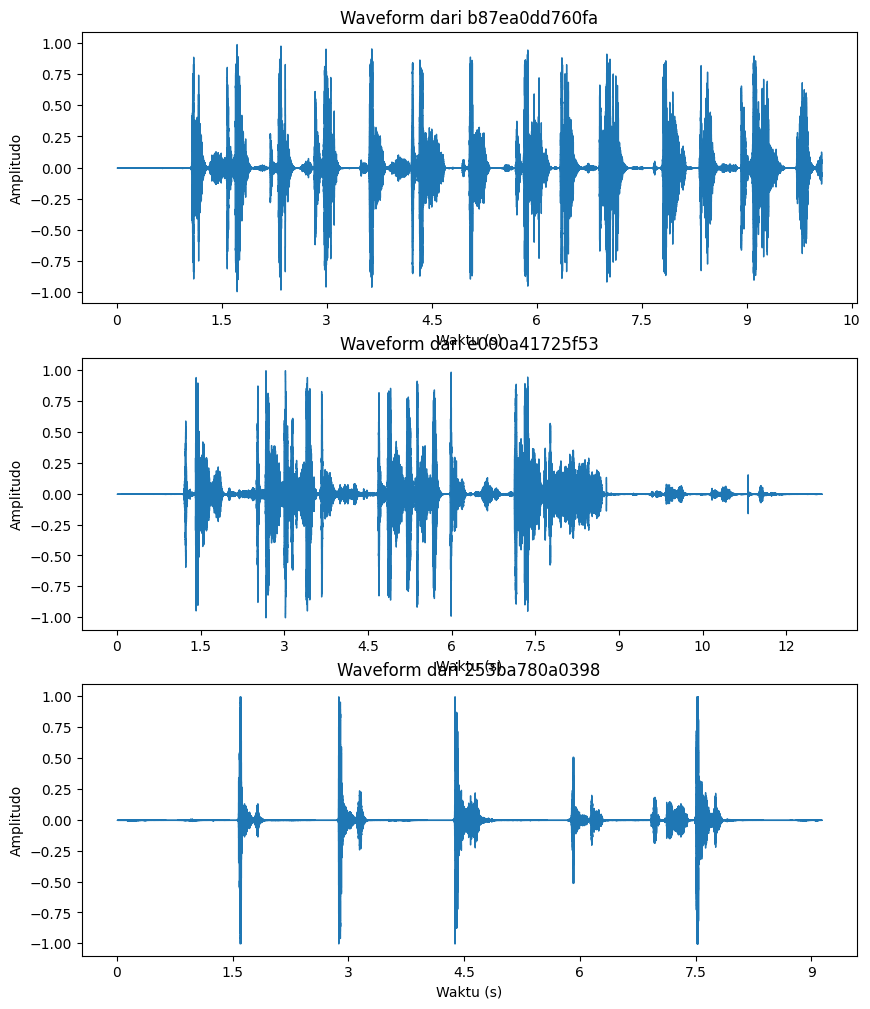

In [4]:
# Define sound folder and candidate IDs
SOUND_FOLDER = "/kaggle/input/airs-ai-in-respiratory-sounds/sounds/sounds"
OUTPUT_FOLDER = "/kaggle/working/waveform_images"  # Folder to save images
os.makedirs(OUTPUT_FOLDER, exist_ok=True)  # Create the folder if it doesn't exist

candidate_ids = ["b87ea0dd760fa", "e000a41725f53", "253ba780a0398"]  # List of candidate IDs

# Generate the list of audio file paths
audio_paths = [os.path.join(SOUND_FOLDER, candidate_id, "cough.wav") for candidate_id in candidate_ids]

# Create subplots for multiple waveforms
fig, axes = plt.subplots(len(audio_paths), 1, figsize=(10, 4 * len(audio_paths)))

# Ensure axes is iterable for a single file
if len(audio_paths) == 1:
    axes = [axes]  

for i, file in enumerate(audio_paths):
    try:
        y, sr = librosa.load(file, sr=None)  # Load audio file
        librosa.display.waveshow(y, sr=sr, ax=axes[i])  # Plot waveform
        axes[i].set_title(f"Waveform dari {candidate_ids[i]}")  # Use candidate ID in title
        axes[i].set_xlabel("Waktu (s)")
        axes[i].set_ylabel("Amplitudo")
    except Exception as e:
        print(f"Error loading {file}: {e}")

# Save the figure
save_path = os.path.join(OUTPUT_FOLDER, "waveforms.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Waveform image saved to: {save_path}")

plt.show()


**Class 1**

**Class 2**

**Class 0**

In [6]:
SOUND_FOLDER = "/kaggle/input/airs-ai-in-respiratory-sounds/sounds/sounds"

data = train
N_MFCC = 20
BATCH_SIZE = 32
SEQ_LENGTH = 512
EMBED_DIM = 512
NUM_HEADS = 8
NUM_FEATURE = len(data.columns) - 2
D_MODELS = EMBED_DIM
EPOCHS = 100

## Data Split & Pipeline

In [7]:
def extract_mfcc(file_path, n_mfcc=N_MFCC, target_length=SEQ_LENGTH):
    try:
        audio, sr = librosa.load(file_path)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        mfcc = mfcc.T
        if len(mfcc) > target_length:
            mfcc = mfcc[:target_length]
        elif len(mfcc) < target_length:
            pad_width = target_length - len(mfcc)
            mfcc = np.pad(mfcc, ((0, pad_width), (0, 0)), mode='constant')
        return mfcc
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

def preprocess_features(row):
    age = row["age"] / 100.0
    pack_years = row["packYears"] / 100.0
    gender = row["gender"]
    tb_contact_history = row["tbContactHistory"]
    wheezing_history = row["wheezingHistory"]
    phlegm_cough = row["phlegmCough"]
    family_asthma_history = row["familyAsthmaHistory"]

    fever_history = row["feverHistory"]

    features = [
        age, gender, pack_years, tb_contact_history, wheezing_history,
        phlegm_cough, family_asthma_history, fever_history
    ]
    features = np.array(features).reshape(-1, 1)
    return features

def process_row(row):
    candidate_id = row["candidateID"]
    audio_path = os.path.join(SOUND_FOLDER, str(candidate_id), "cough.wav")
    mfcc = extract_mfcc(audio_path)
    features = preprocess_features(row)
    label = row["disease"]
    label = tf.one_hot(label, depth=3)
    return mfcc, features, label

def data_generator(data):
    for _, row in data.iterrows():
        mfcc, features, label = process_row(row)
        yield mfcc, features, label

def create_dataset(data, batch_size=BATCH_SIZE):
    output_signature = (
        tf.TensorSpec(shape=(SEQ_LENGTH, N_MFCC), dtype=tf.float32),
        tf.TensorSpec(shape=(NUM_FEATURE, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(3,), dtype=tf.int32),
    )
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(data),
        output_signature=output_signature
    )
    return dataset.batch(batch_size).shuffle(256).prefetch(tf.data.AUTOTUNE)

def split_data(data, test_size=0.2, random_state=25):
    train_data, valid_data = train_test_split(
        data, test_size=test_size, random_state=random_state, stratify=data['disease']
    )
    return train_data, valid_data

train_data_df, valid_data_df = split_data(data)

train_dataset = create_dataset(train_data_df, batch_size=BATCH_SIZE)
valid_dataset = create_dataset(valid_data_df, batch_size=BATCH_SIZE)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.int32, name=None))>

## Transformer Component

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, embed_dim, trainable_embed=False, **kwargs):
        super().__init__(**kwargs)
        
        # Generate positional encoding matrix
        position_embedding_matrix = self.get_position_encoding(sequence_length, embed_dim)
        
        # Non-trainable Embedding layer to store positional encodings
        if trainable_embed == False:
            self.position_embedding_layer = layers.Embedding(
                input_dim=sequence_length, output_dim=embed_dim,
                weights=[position_embedding_matrix],
                trainable=False
            )
        else:
            self.position_embedding_layer = layers.Embedding(
                input_dim=sequence_length, output_dim=embed_dim,
                trainable=True
            )
             
    def get_position_encoding(self, seq_len, d, n=10000):
        P = np.zeros((seq_len, d))
        for k in range(seq_len):
            for i in np.arange(int(d/2)):
                denominator = np.power(n, 2*i/d)
                P[k, 2*i] = np.sin(k/denominator)
                P[k, 2*i+1] = np.cos(k/denominator)
        return P
 
    def call(self, inputs):        
        # Get position indices (0, 1, ..., sequence_length-1)
        sequence_length = tf.shape(inputs)[1]  # Ambil sequence_length dari inputs
        position_indices = tf.range(sequence_length)  # Shape: (sequence_length,)
        
        # Get positional encoding
        positional_encoding = self.position_embedding_layer(position_indices)  # Shape: (sequence_length, embed_dim)
        
        # Expand dimensions for broadcasting: (1, sequence_length, embed_dim)
        return positional_encoding[tf.newaxis, :, :]


class TransformerEncoderBlock(tf.keras.Model):
    def __init__(self, d_models, num_heads, num_layers=6, **kwargs):
        super().__init__(**kwargs)

        self.dense256 = layers.Dense(256, activation="relu")
        self.dense_transform = layers.Dense(d_models, activation="relu")
        self.num_layers = num_layers
        self.linear = layers.Dense(d_models, activation="relu")

        self.frame_positional_encoding = PositionalEncoding(
            sequence_length=NUM_FEATURE + 1, embed_dim=d_models, trainable_embed=True
        )
        self.patch_positional_encoding = PositionalEncoding(
            sequence_length=SEQ_LENGTH + 1, embed_dim=d_models, trainable_embed=True
        )

        # Define layers as lists
        self.attention_frame = [layers.MultiHeadAttention(num_heads=num_heads, key_dim=int(d_models/num_heads), dropout=0.1) 
                                for _ in range(num_layers)]
        self.attention_cross = [layers.MultiHeadAttention(num_heads=num_heads, key_dim=int(d_models/num_heads), dropout=0.1) 
                                for _ in range(num_layers)]
        self.layernorm_frame = [layers.LayerNormalization() for _ in range(num_layers)]
        self.layernorm_cross = [layers.LayerNormalization() for _ in range(num_layers)]
        self.dense_1 = [layers.Dense(d_models, activation="gelu") for _ in range(num_layers)]
        self.dense_2 = [layers.Dense(d_models) for _ in range(num_layers)]
        self.dropout = [layers.Dropout(0.1) for _ in range(num_layers)]

        # Learnable class tokens
        self.cls_token = self.add_weight(
            shape=(1, 1, d_models),
            initializer="random_normal",
            trainable=True,
            name="cls_token"
        )

        self.cls_token2 = self.add_weight(
            shape=(1, 1, d_models),
            initializer="random_normal",
            trainable=True,
            name="cls_token2"
        )

        # Final output layers
        self.out = layers.Dense(d_models, activation="gelu")
        self.out_drop = layers.Dropout(0.1)

    def call(self, inputs, training=False):
        """Transformer Encoder Forward Pass"""
        inputs, frame = inputs

        # Add class token
        batch_size = tf.shape(inputs)[0]
        inputs = self.dense_transform(self.dense256(inputs))
        cls_tokens = tf.broadcast_to(self.cls_token, [batch_size, 1, tf.shape(self.cls_token)[-1]])
        cls_tokens2 = tf.broadcast_to(self.cls_token2, [batch_size, 1, tf.shape(self.cls_token2)[-1]])

        # Process frame
        frame = self.linear(frame)
        frame = tf.concat([cls_tokens2, frame], axis=1)
        Zt = layers.Add()([frame, self.frame_positional_encoding(frame)])

        # Process inputs
        inputs = tf.concat([cls_tokens, inputs], axis=1)
        Zs = layers.Add()([inputs, self.patch_positional_encoding(inputs)])

        # Iterate over pre-defined layers (avoid Graph Mode error)
        for i in range(self.num_layers):
            Zt = self.layernorm_frame[i](Zt + self.attention_frame[i](query=Zt, value=Zt, key=Zt, training=training))
            Zts = tf.concat([Zs, Zt], axis=1)
            Zs = self.layernorm_cross[i](Zs + self.attention_cross[i](query=Zs, value=Zts, key=Zts, training=training))

            inputs = self.dense_1[i](Zs)
            inputs = self.dropout[i](inputs, training=training)
            inputs = self.dense_2[i](inputs)
            Zs += inputs

            inputsf = self.dense_1[i](Zt)
            inputsf = self.dropout[i](inputsf, training=training)
            inputsf = self.dense_2[i](inputsf)
            Zt += inputsf

        # Output
        Zt = Zt[:, 0, :]
        Zs = Zs[:, 0, :]
        out = tf.concat([Zs, Zt], axis=-1)
        out = self.out(out)
        out = self.out_drop(out)
        return out


    def create_look_ahead_mask(self, size):
        return tf.linalg.band_part(tf.ones((size, size)), -1, 0)


class Classifier(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.densel = layers.Dense(EMBED_DIM)
        self.out = layers.Dense(3, activation="softmax")

    def call(self, inputs):
        x = self.densel(inputs)
        x = self.out(x)
        return x


@keras.saving.register_keras_serializable()
class MainModel(keras.Model):
    def __init__(self, encoder, classifier, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.classifier = classifier
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")

    def call(self, inputs, training=False):
        """Forward pass through encoder and classifier"""
        encoder_out = self.encoder(inputs, training=training)
        preds = self.classifier(encoder_out)
        return preds  # Returns predicted probabilities

    def calculate_loss(self, y_pred, y_true):
        return self.loss(y_true, y_pred)

    def calculate_acc(self, y_pred, y_true):
        predicted_classes = tf.argmax(y_pred, axis=1)
        y_true = tf.argmax(y_true, axis=1)
        accuracy = tf.reduce_mean(tf.cast(tf.equal(y_true, predicted_classes), dtype=tf.float32))
        return accuracy

    def train_step(self, batch_data):
        batch, batch2, label = batch_data

        with tf.GradientTape() as tape:
            preds = self(inputs=[batch, batch2], training=True)
            batch_loss = self.calculate_loss(preds, label)
            batch_acc = self.calculate_acc(preds, label)

        train_vars = self.trainable_variables
        grads = tape.gradient(batch_loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))

        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        return {"loss": self.loss_tracker.result(), "accuracy": self.acc_tracker.result()}

    def test_step(self, batch_data):
        batch, batch2, label = batch_data
        preds = self(inputs=[batch, batch2], training=False)
        batch_loss = self.calculate_loss(preds, label)
        batch_acc = self.calculate_acc(preds, label)

        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        return {"loss": self.loss_tracker.result(), "accuracy": self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]

## Modeling

In [15]:
encoder = TransformerEncoderBlock(d_models=D_MODELS, num_heads=NUM_HEADS)
classifier = Classifier()
model = MainModel(encoder, classifier)

## Training

In [16]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        return {
            "d_model": self.d_model.numpy(),  # Konversi ke tipe Python agar bisa diserialisasi
            "warmup_steps": self.warmup_steps
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [17]:
# Define the loss function
cross_entropy = keras.losses.CategoricalCrossentropy()

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(monitor = "val_loss", mode='min', patience=10, restore_best_weights=True)
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0000001)
# Optimizer
lr = CustomSchedule(D_MODELS)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr,
    beta_1=0.9,
    beta_2=0.98,
    epsilon=1e-9
)

# Compile the model
model.compile(optimizer=optimizer, loss=cross_entropy)

In [18]:
model.summary()

Model: "main_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ transformer_encoder_block_1          │ ?                           │     0 (unbuilt) │
│ (TransformerEncoderBlock)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classifier_1 (Classifier)            │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,024 (4.00 KB)

 Trainable params: 1,024 (4.00 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
#Fit the model
history = model.fit(train_dataset, epochs=EPOCHS, validation_data=valid_dataset, callbacks=[early_stopping])

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.4439 - loss: 1.7494 - val_accuracy: 0.3341 - val_loss: 1.1130
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 588ms/step - accuracy: 0.3676 - loss: 1.2923 - val_accuracy: 0.3035 - val_loss: 1.0929
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 591ms/step - accuracy: 0.3768 - loss: 1.2315 - val_accuracy: 0.4008 - val_loss: 1.0275
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 568ms/step - accuracy: 0.3689 - loss: 1.2221 - val_accuracy: 0.4435 - val_loss: 1.0318
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 585ms/step - accuracy: 0.4216 - loss: 1.1812 - val_accuracy: 0.4555 - val_loss: 1.0374
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 588ms/step - accuracy: 0.4182 - loss: 1.0613 - val_accuracy: 0.4675 - val_loss: 0.9564
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 579ms/step - accuracy: 0.5791 - loss: 0.9486 - val_accuracy: 0.5258 - val_loss: 0.8995
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 592ms/step - accuracy: 0.5677 - loss: 0.9100 - va

### Visualize Training Accuracy & Loss

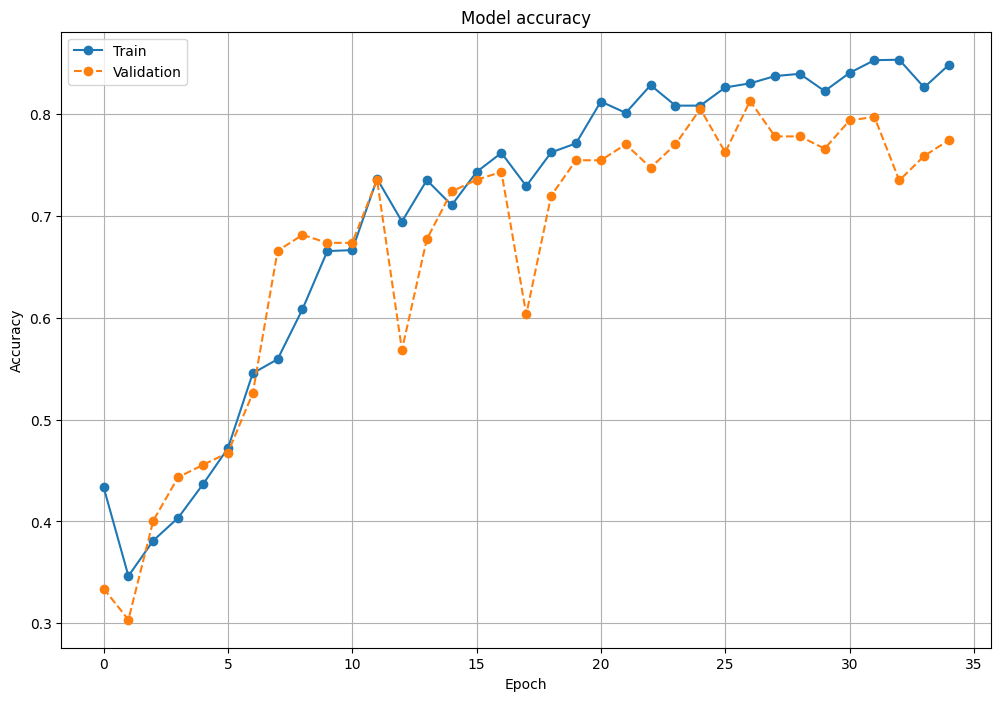

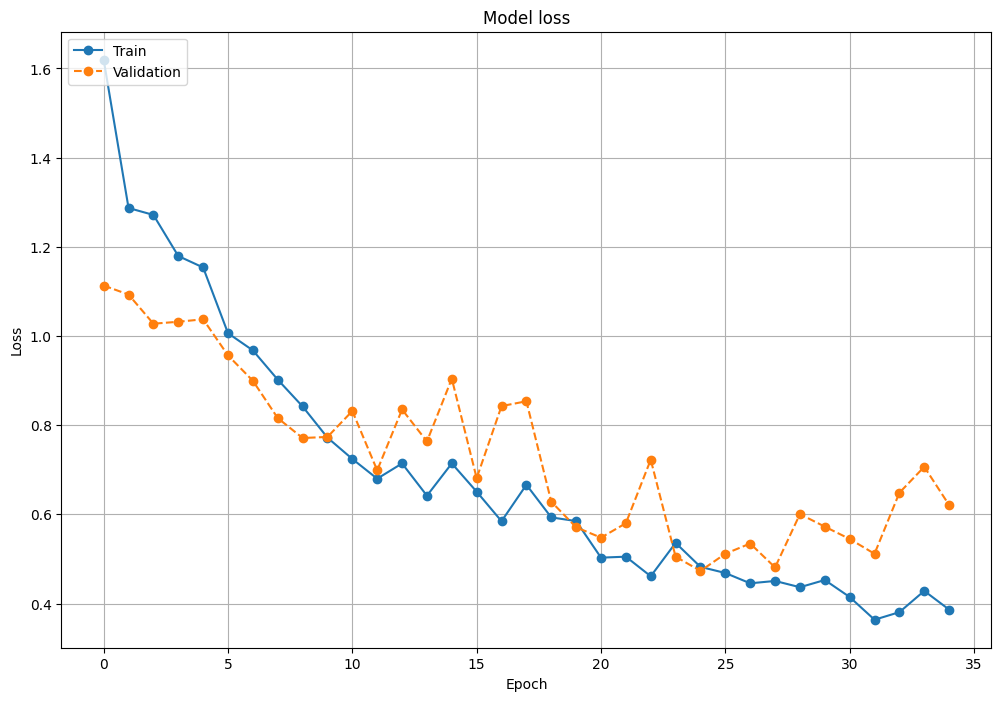

In [36]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], marker='o', linestyle='-')
plt.plot(history.history['val_accuracy'], marker='o', linestyle='--')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'], marker='o', linestyle='-')
plt.plot(history.history['val_loss'], marker='o', linestyle='--')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()

### Save Model

In [21]:
# Save the entire model as a `.keras` zip archive.
model.save('big_model_lung_disease_classification_transformer.keras')

In [22]:
model.save_weights("model_weights.weights.h5")

## Predict New Data

### Data Processing

In [23]:
test = pd.read_csv("/kaggle/input/airs-ai-in-respiratory-sounds/test.csv")
print(test.info())
print(test.isnull().sum())
test

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   candidateID          338 non-null    object 
 1   age                  338 non-null    int64  
 2   gender               338 non-null    int64  
 3   tbContactHistory     338 non-null    float64
 4   wheezingHistory      338 non-null    float64
 5   phlegmCough          338 non-null    float64
 6   familyAsthmaHistory  338 non-null    float64
 7   feverHistory         338 non-null    int64  
 8   coldPresent          291 non-null    float64
 9   packYears            338 non-null    int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 26.5+ KB
None
candidateID             0
age                     0
gender                  0
tbContactHistory        0
wheezingHistory         0
phlegmCough             0
familyAsthmaHistory     0
feverHistory            0
coldPresent        

,candidateID,age,gender,tbContactHistory,wheezingHistory,phlegmCough,familyAsthmaHistory,feverHistory,coldPresent,packYears
0,136bac9a3e081,23,0,0.0,0.0,0.0,0.0,0,NaN,9
1,b121e45942a46,26,1,0.0,0.0,0.0,1.0,0,NaN,0
2,6b6853c07e4fb,26,1,1.0,0.0,0.0,0.0,1,NaN,0
3,71de185eac888,55,0,0.0,0.0,0.0,0.0,1,NaN,0
4,25deed742f133,16,0,0.0,0.0,0.0,0.0,1,NaN,0
...,...,...,...,...,...,...,...,...,...,...
333,08aac13482ff8,46,0,0.0,0.0,1.0,0.0,0,1.0,0
334,9a8601c8de4fd,54,0,0.0,0.0,1.0,0.0,0,0.0,0
335,fa284742bf6a5,57,0,0.0,0.0,1.0,0.0,0,0.0,560
336,583f6d1a089ce,22,1,0.0,0.0,1.0,0.0,1,0.0,0


In [24]:
test = test.drop(columns=["coldPresent"])
test.isnull().sum()

candidateID            0
age                    0
gender                 0
tbContactHistory       0
wheezingHistory        0
phlegmCough            0
familyAsthmaHistory    0
feverHistory           0
packYears              0
dtype: int64

In [25]:
#new_data_dataset = new_data_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [26]:
# Recreate the model instance (architecture must match)
#model = MainModel(encoder=TransformerEncoderBlock(d_models=EMBED_DIM, num_heads=NUM_HEADS), classifier=Classifier())

# Load the saved weights
#model.load_weights("/kaggle/working/model_weights.weights.h5")

In [27]:
def extract_mfcc(file_path, n_mfcc=N_MFCC, target_length=SEQ_LENGTH):
    try:
        audio, sr = librosa.load(file_path)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        mfcc = mfcc.T
        if len(mfcc) > target_length:
            mfcc = mfcc[:target_length]
        elif len(mfcc) < target_length:
            pad_width = target_length - len(mfcc)
            mfcc = np.pad(mfcc, ((0, pad_width), (0, 0)), mode='constant')
        return mfcc
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

def preprocess_features(row):
    age = row["age"] / 100.0
    pack_years = row["packYears"] / 100.0
    gender = row["gender"]
    tb_contact_history = row["tbContactHistory"]
    wheezing_history = row["wheezingHistory"]
    phlegm_cough = row["phlegmCough"]
    family_asthma_history = row["familyAsthmaHistory"]

    fever_history = row["feverHistory"]

    features = [
        age, gender, pack_years, tb_contact_history, wheezing_history,
        phlegm_cough, family_asthma_history, fever_history
    ]
    features = np.array(features).reshape(-1, 1)
    return features

def process_row(row):
    candidate_id = row["candidateID"]
    audio_path = os.path.join(SOUND_FOLDER, str(candidate_id), "cough.wav")
    mfcc = extract_mfcc(audio_path)
    features = preprocess_features(row)
    mfcc = tf.convert_to_tensor(mfcc, dtype=tf.float32)
    features = tf.convert_to_tensor(features, dtype=tf.float32)
    mfcc.set_shape((SEQ_LENGTH, N_MFCC))
    features.set_shape((NUM_FEATURE, 1))
    mfcc = tf.expand_dims(mfcc, axis=0)
    features = tf.expand_dims(features, axis=0)
    return mfcc, features

def predict(model, mfcc, features):
    encoder_out = model.encoder([mfcc, features], training=False)
    pred = model.classifier(encoder_out)
    predicted_classes = tf.argmax(pred, axis=1)
    return int(predicted_classes[0])


In [28]:
test_dict = test.to_dict(orient="records")

### Prediksi data baru

In [29]:
# List untuk menyimpan hasil prediksi
results = []

for row in test_dict:
    mfcc, features = process_row(row)  # Proses data
    prediction = predict(model, mfcc, features)  # Prediksi

    # Tambahkan hasil ke list
    results.append({
        "candidateID": row["candidateID"],
        "disease": prediction
    })

# Konversi hasil ke DataFrame
results_df = pd.DataFrame(results)

# Simpan ke CSV
output_path = "/kaggle/working/predictions.csv"
results_df.to_csv(output_path, index=False)

print(f"Hasil prediksi disimpan di: {output_path}")


Hasil prediksi disimpan di: /kaggle/working/predictions.csv
